# DQN Atari Games


In [1]:
%matplotlib inline

import gym
from gym import wrappers, logger
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import collections
from collections import namedtuple
import math
import random
import cv2
import os
from os import path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from definitions import ROOT_DIR
from utils.system_utils import get_path
# from preprocessing.atari import preprocess_breakout
# from models.dqn import AtariDQN

### Global parameters

In [2]:
ENV_NAME = 'Breakout-v0'

N_EPISODES = 100
D = (1, 40, 40)  # Dimension of the frame after preprocessing BCHW

FIG_SIZE = (15, 8)  # Usefull for stats plotting
USE_CUDA = False
RENDER_ENV = True

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

GAMMA = 0.999
BATCH_SIZE = 32
MEMORY_LIMIT = 10 ** 4
TARGET_UPDATE = 10  # Every TARGET_UPDATE episode update the state_value_net weights copying from the policy_net

MODEL_SAVE_FOLDER = path.join(ROOT_DIR, 'pretrained-models', ENV_NAME)

Stats = namedtuple('Stats', ('episode_lengths', 'episode_rewards'))

device = torch.device("cuda" if USE_CUDA else "cpu")

### Env manipulation just to speed-up the game and the training

In [3]:
def wrap_env(env, task_name, logger_level=logger.INFO):
    logger.set_level(logger_level)

    outdir = os.path.join(ROOT_DIR, 'logs/' + task_name + '-results')

    return wrappers.Monitor(env, directory=outdir, force=True)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        """Take action on reset for environments that are fixed until firing."""
        super(FireResetEnv, self).__init__(env)
        print(env.unwrapped.get_action_meanings())
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

def make_env_skip(env_name, env_is_wrapped=False):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    if env_is_wrapped:
        env = wrap_env(env, env_name)
    return env

### Init the env

In [4]:
env = make_env_skip(ENV_NAME, True)

['NOOP', 'FIRE', 'RIGHT', 'LEFT']
INFO: Clearing 8 monitor files from previous run (because force=True was provided)


### Define the NNs

In [5]:
class AtariDQN(nn.Module):

    def __init__(self, input_shape, n_actions):
        """
        Deep-Q-Network (DQN) is composed of:
            - 3 convolution layers
            - 2 fully-connected linear layers
            """

        super(AtariDQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))  # Compute the output of the conv part of the network to find its final dimension
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

### Initialize the NNs and optimizer

In [6]:
policy_net = AtariDQN(D, env.action_space.n).to(device)
state_value_net = AtariDQN(D, env.action_space.n).to(device)

state_value_net.load_state_dict(policy_net.state_dict())
state_value_net.eval()

# Init the RMSprop optimizer to spped-up the mini-batch learning
optimizer = optim.RMSprop(policy_net.parameters())

print(policy_net)
print(state_value_net)

AtariDQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)
AtariDQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_featu

### Preprocessing for game frames

In [7]:
def preprocess_breakout(image):
    image = image[32: 192]  # Crop the not necessary part of the image
    image = cv2.resize(image, (80, 80))
    image = image[::2, ::2, ::3]
    image[image != 0] = 1
    image = np.expand_dims(np.rollaxis(image, 2, 0), axis=0)
    return torch.from_numpy(image).type(torch.float)

### Experience replay object

In [8]:
class ExperienceReplay(object):

    def __init__(self, capacity, experience):
        self.capacity = capacity
        self.experience = experience
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Save a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = self.experience(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, as_tuple=False):
        samples = random.sample(self.memory, batch_size)
        if as_tuple:
            return self.experience(*zip(*samples))
        else:
            return samples

    def __len__(self):
        return len(self.memory)

### Define the game Agent

In [9]:
Experience = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward'))

class BreakoutAgent:

    def __init__(self,
                 env,
                 state_shape=(1, 80, 80),
                 render_env=False,
                 epsilon_start=0.9,
                 epsilon_end=0.05,
                 epsilon_decay=200,
                 gamma=0.999,
                 batch_size=128,
                 experience=Experience,
                 memory_limit=10 ** 4
                 ):
        self.env = env
        self.state_shape = state_shape
        self.render_env = render_env
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon = epsilon_start
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = ExperienceReplay(memory_limit, experience)

    def _update_espilon(self, steps_done):
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                       math.exp(-1. * steps_done / self.epsilon_decay)

    def reset(self):
        return preprocess_breakout(self.env.reset())

    def render(self):
        if self.render_env:
            return self.env.render()
        else:
            return None

    def memory_push(self, *args):
        self.memory.push(*args)

    def memory_sample(self, as_tuple=False):
        return self.memory.sample(self.batch_size, as_tuple=as_tuple)

    def choose_action(self, state, policy_net, steps_done):
        # Update epsilon
        self._update_espilon(steps_done)
        sample = random.random()

        if sample < self.epsilon:
            # Perform a random action selection
            return random.randrange(self.env.action_space.n)
        else:
            # Choose an action accordingly to the policy parameterization
            # -> choose the action with the highest probability accordingly the policy
            with torch.no_grad():
                # Feed the policy network with the state -> obtain the probability for each action
                action_prob = policy_net(state)
                # t.max(1) compute the max and return a tuple (max_val, max_index)
                # We need the action (so the index)
                return action_prob.max(1)[1].item()

    def optimize_model(self, policy_net, state_value_net, optimizer, device='cpu'):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory_sample(as_tuple=True)

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        next_state_values[non_final_mask] = state_value_net(non_final_next_states).max(1)[0].detach()

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        for param in policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()

    def act(self, action):
        state, reward, done, info = self.env.step(action)
        return preprocess_breakout(state), reward, done, info

    def close(self):
        return self.env.close()

### Initiate the game Agent

In [10]:
agent = BreakoutAgent(env, 
                      state_shape=D,
                      render_env=RENDER_ENV,
                      epsilon_start=EPS_START, 
                      epsilon_end=EPS_END,
                      epsilon_decay=EPS_DECAY,
                      gamma=GAMMA,
                      batch_size=BATCH_SIZE,
                      experience=Experience,
                      memory_limit=MEMORY_LIMIT
                     )

### Training loop

In [11]:

episode_length = 0
total_reward = np.zeros(N_EPISODES)
best_episode_reward = None

stats = Stats(
    episode_lengths=np.zeros(N_EPISODES),
    episode_rewards=np.zeros(N_EPISODES)
)

last_state = None

for i_episode in range(N_EPISODES):
    done = False

    # Reset the env after each episode termination
    current_state = agent.reset()
    state = current_state

    while not done:
        agent.render()
        action = agent.choose_action(state=state, policy_net=policy_net, steps_done=episode_length)
        current_state, reward, done, info = agent.act(action)

        # Compute state difference between previous and current state
        if not done:
            next_state = current_state - last_state if last_state is not None else torch.zeros((1, *D))
        else:
            next_state = None
        last_state = current_state
        
        # Necessary for the sake of compatibility with torch when using it in the optimize_model method
        action = torch.tensor([[action]], device=device)  
        reward = torch.tensor([reward], device=device)
        # Push an experience tuple in the memory
        agent.memory_push(current_state, action, next_state, reward)

        total_reward[i_episode] += reward
        
        # Move to the next state
        state = next_state
        
         # Perform one step of the optimization (on the target network)
        agent.optimize_model(
            policy_net=policy_net,
            state_value_net=state_value_net,
            optimizer=optimizer,
            device=device
        )

        # print('Episode: {} | Reward: {} | Total episode reward: {} | Episodes total reward mean {} | Info: {}'
        #      .format(i_episode + 1, reward, total_reward[i_episode], total_reward.mean(), info))
        episode_length += 1

    # Update the state_value_net network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        state_value_net.load_state_dict(policy_net.state_dict())
    
    print('Episode {} terminated after {} frames'.format(i_episode + 1, episode_length + 1))
    stats.episode_lengths[i_episode] = episode_length
    stats.episode_rewards[i_episode] = total_reward[i_episode]
    episode_length = 0
    last_state = None
    
    # Check if I have to save the model because has the best reward until now
    if best_episode_reward is None or best_episode_reward < total_reward[i_episode]:
        save_path = get_path(MODEL_SAVE_FOLDER)
        torch.save(policy_net.state_dict(), path.join(save_path, 'reward-' + str(total_reward[i_episode]) + '.pth'))
        best_episode_reward = total_reward[i_episode]
        print('New best model founded with reward: {} (model is saved)'.format(best_episode_reward))

agent.close()
print(stats)


INFO: Starting new video recorder writing to /Users/alessandrostaffolani/Workspace/Thesis/gym-trials/logs/Breakout-v0-results/openaigym.video.0.3701.video000000.mp4
Episode 1 terminated after 78 frames
New best model founded with reward: 2.0 (model is saved)
INFO: Starting new video recorder writing to /Users/alessandrostaffolani/Workspace/Thesis/gym-trials/logs/Breakout-v0-results/openaigym.video.0.3701.video000001.mp4
Episode 2 terminated after 79 frames
Episode 3 terminated after 79 frames
Episode 4 terminated after 56 frames
Episode 5 terminated after 81 frames
Episode 6 terminated after 62 frames
Episode 7 terminated after 47 frames
Episode 8 terminated after 87 frames
New best model founded with reward: 3.0 (model is saved)
INFO: Starting new video recorder writing to /Users/alessandrostaffolani/Workspace/Thesis/gym-trials/logs/Breakout-v0-results/openaigym.video.0.3701.video000008.mp4
Episode 9 terminated after 74 frames
Episode 10 terminated after 72 frames
Episode 11 terminate

### Show stats

#### Episode length over time

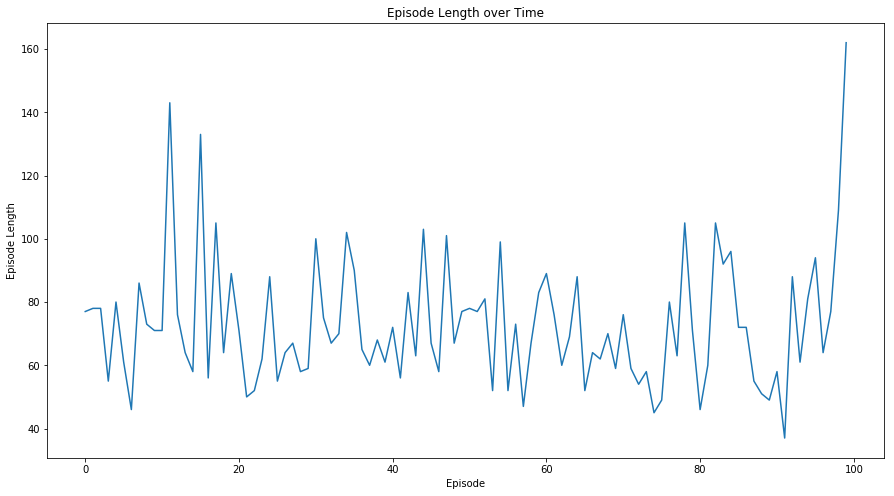

In [12]:
fig1 = plt.figure(figsize=FIG_SIZE)
plt.plot(stats.episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Length over Time")
plt.show(fig1)

#### Episode reward over time

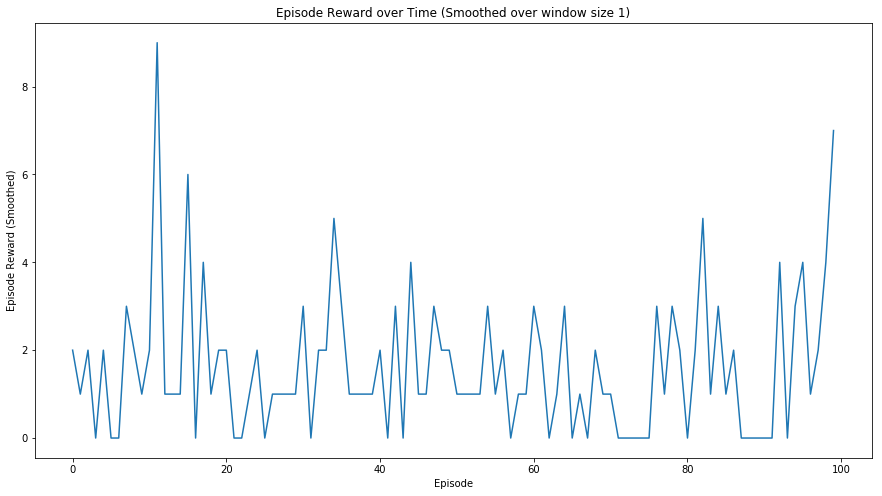

In [13]:
fig2 = plt.figure(figsize=FIG_SIZE)
smoothing_window = 1
goal_value = None
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
plt.plot(rewards_smoothed)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
title = "Episode Reward over Time (Smoothed over window size {})".format(smoothing_window)

if goal_value is not None:
    plt.axhline(goal_value, color='g', linestyle='dashed')
    title = "Episode Reward over Time (Smoothed over window size" \
            " " + str(smoothing_window) + ", goal value " + str(goal_value) + ")"

plt.title(title)
plt.show(fig2)